In [6]:
%matplotlib qt

import pyxdf


In [7]:

fname = "../data/sub-P406/ses-S001/eeg/sub-P406_ses-S001_task-Default_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fname)

In [9]:
prediciton_stream = streams[0]["time_series"]

In [10]:
for stream in streams: 
    print(stream['info']['name'])

['UnityStream']
['UnityPositionStream']
['PredictionStream']
['BioSemi']


In [5]:
eeg_streams = streams[1]['time_series'].T

In [130]:
eeg_streams

array([[-7.7985280e+06, -7.7985280e+06, -7.7985280e+06, ...,
        -7.7985280e+06, -7.7985280e+06, -7.7985280e+06],
       [ 9.6700625e+03,  9.6706875e+03,  9.6742188e+03, ...,
         1.0936344e+04,  1.0932969e+04,  1.0935500e+04],
       [ 1.6878906e+04,  1.6877219e+04,  1.6879938e+04, ...,
         1.7817625e+04,  1.7815031e+04,  1.7817094e+04],
       ...,
       [ 6.2353219e+04,  6.2352719e+04,  6.2353219e+04, ...,
         6.1825969e+04,  6.1826219e+04,  6.1826469e+04],
       [-3.1250000e-02, -3.1250000e-02, -3.1250000e-02, ...,
        -3.1250000e-02, -3.1250000e-02, -3.1250000e-02],
       [-3.1250000e-02, -3.1250000e-02, -3.1250000e-02, ...,
        -3.1250000e-02, -3.1250000e-02, -3.1250000e-02]], dtype=float32)

In [7]:
import mne
import os
import pathlib
import sys
SCRIPT_DIR = pathlib.Path.cwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
from continuous_control_bci.util import channel_names
import matplotlib.pyplot as plt



In [8]:
import numpy as np
print(np.max(eeg_streams[1:41, :] / 10e5))
print(np.min(eeg_streams[1:41, :] / 10e5))
eeg_streams[1:41, :] / 10e5

0.020563
-0.015628938


array([[ 0.00967006,  0.00967069,  0.00967422, ...,  0.01093634,
         0.01093297,  0.0109355 ],
       [ 0.01687891,  0.01687722,  0.01687994, ...,  0.01781763,
         0.01781503,  0.01781709],
       [ 0.01342369,  0.01342091,  0.01342209, ...,  0.01495403,
         0.01494759,  0.01494762],
       ...,
       [-0.0153525 , -0.01535597, -0.01535613, ..., -0.01298775,
        -0.01298981, -0.01299384],
       [-0.01458056, -0.01458175, -0.01458125, ..., -0.01211984,
        -0.01212425, -0.01212291],
       [-0.01150147, -0.01150191, -0.01150103, ..., -0.00950841,
        -0.00951797, -0.00951784]], dtype=float32)

In [91]:
# We need to ignore the 0th, because that captures the CMS/DRL homehow
# The last 16 are related to USB triggers that the box can receive. These should also be ignored

raw = mne.io.RawArray(eeg_streams[1:41, :] / 10e5, info=mne.create_info(channel_names, sfreq=2048))
raw.plot()
plt.show()

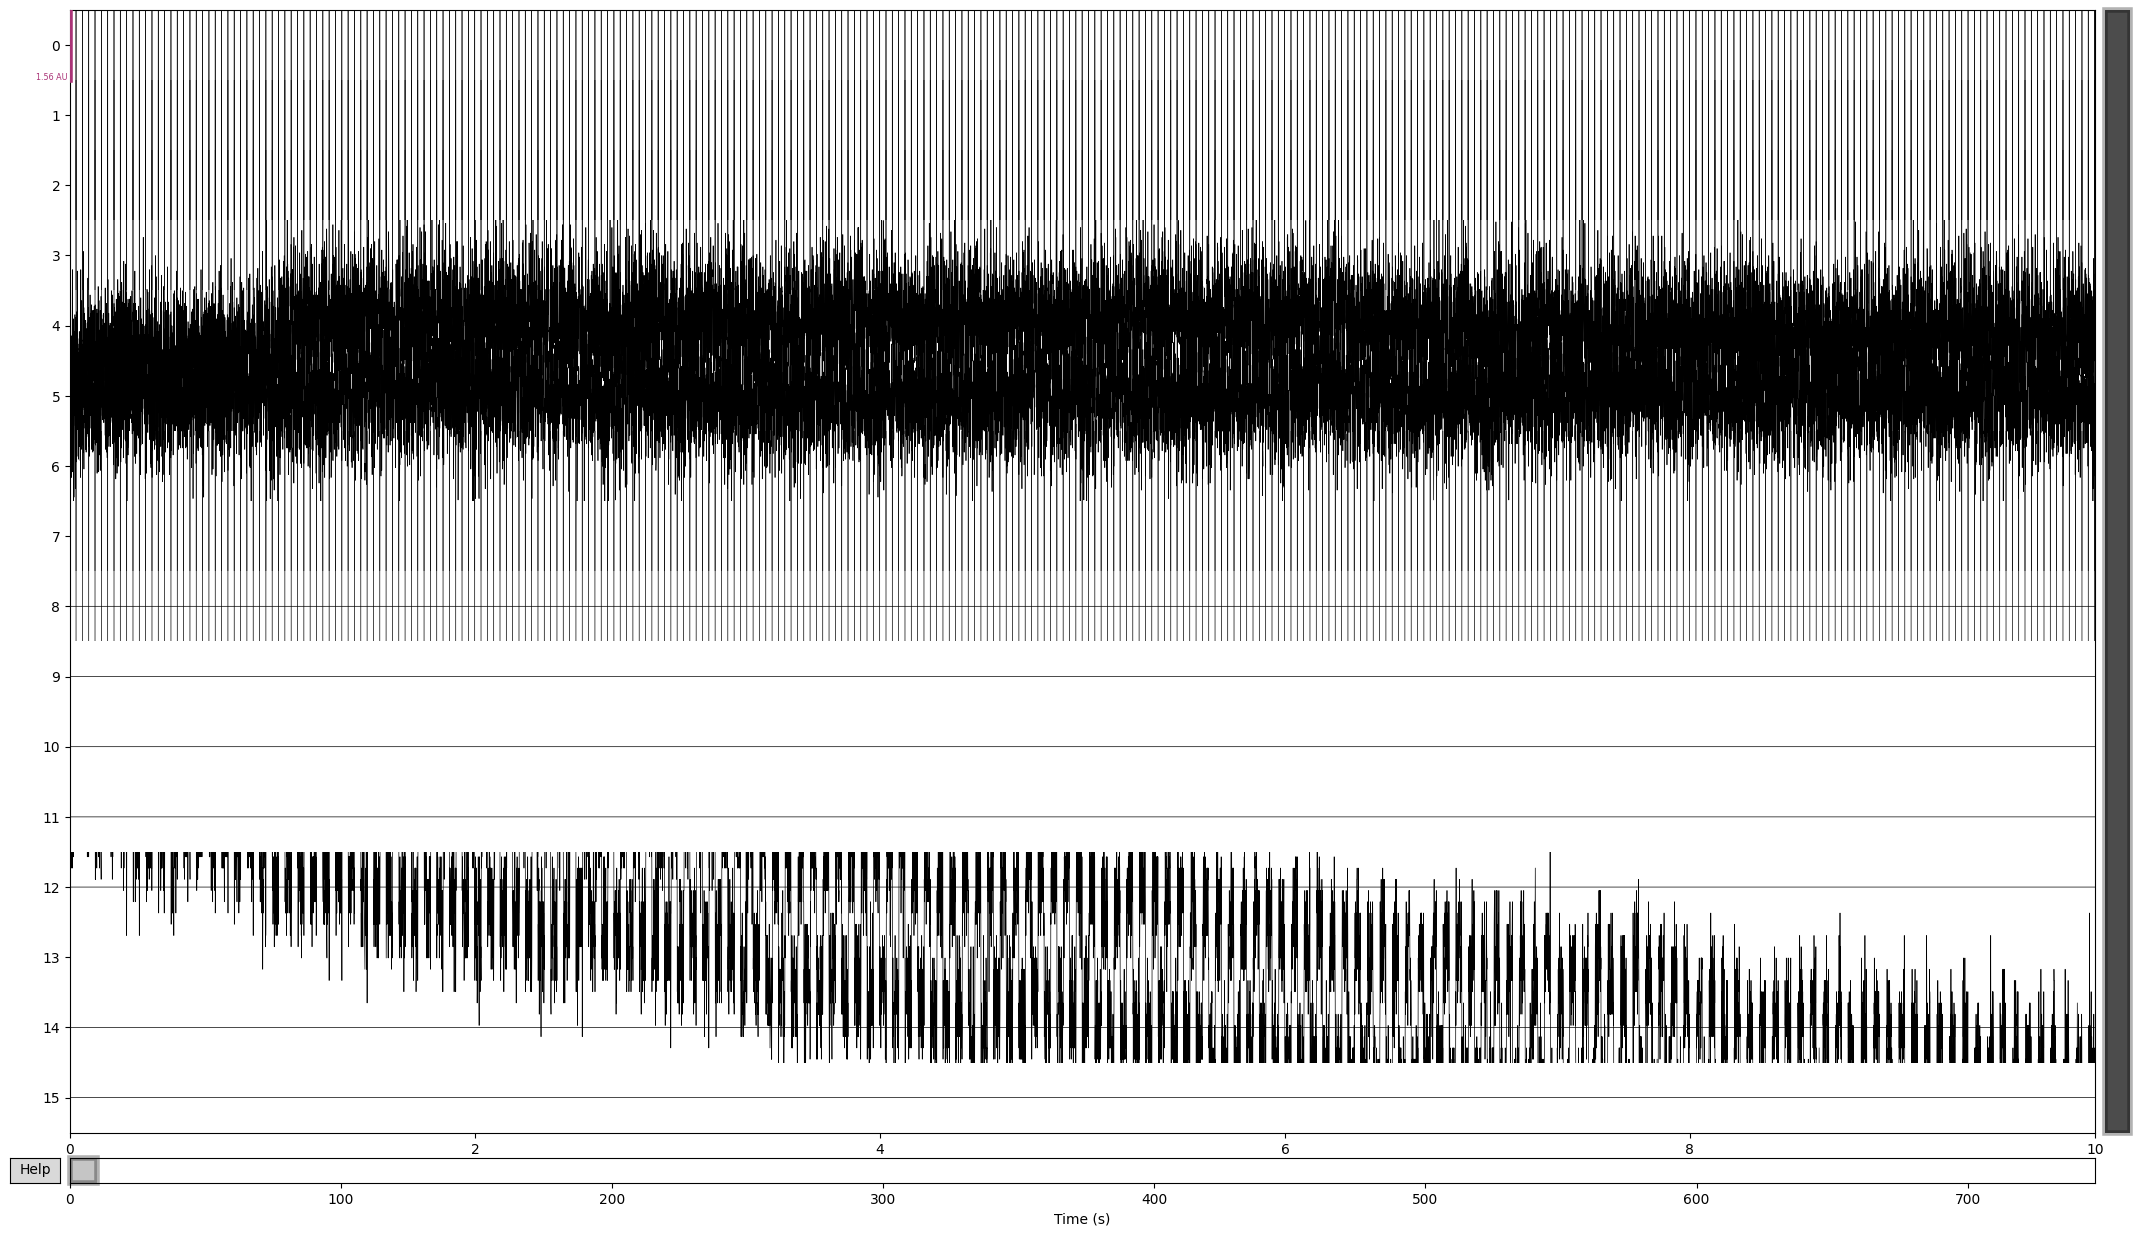

In [92]:
mne.io.RawArray(eeg_streams[41:, :], info=mne.create_info(eeg_streams[41:, :].shape[0], sfreq=2048)).plot()
# the 5th here (channel 46)

# The ActiveTwo USB receiver has 16 independent trigger inputs. This is probably what's going on somehow. That's why we have exactly 16 extra channels.
# https://www.biosemi.com/faq/trigger_signals.htm

In [93]:
eeg_streams[41:, :]
# 0, 1, 2, 3, 6 and 7 all follow a square wave
# 4, 5 and 13 actually seem to get a signal, but I'm not sure what
# 

array([[ 9.50845000e+04,  9.58203438e+04,  9.63831250e+04, ...,
        -1.31053312e+05, -1.31052844e+05, -1.31053719e+05],
       [-1.31052594e+05, -1.31061125e+05, -1.31064250e+05, ...,
         1.01372094e+05,  1.01443250e+05,  1.01512125e+05],
       [ 9.48510000e+04,  9.56255625e+04,  9.62106875e+04, ...,
        -1.31071094e+05, -1.31072531e+05, -1.31071375e+05],
       ...,
       [ 6.23532188e+04,  6.23527188e+04,  6.23532188e+04, ...,
         6.18259688e+04,  6.18262188e+04,  6.18264688e+04],
       [-3.12500000e-02, -3.12500000e-02, -3.12500000e-02, ...,
        -3.12500000e-02, -3.12500000e-02, -3.12500000e-02],
       [-3.12500000e-02, -3.12500000e-02, -3.12500000e-02, ...,
        -3.12500000e-02, -3.12500000e-02, -3.12500000e-02]], dtype=float32)

In [94]:
import numpy as np
prediction_timestamps = streams[0]['time_stamps']
prediction_values = streams[0]['time_series']

print(prediction_timestamps.shape)
print(prediction_values[:, 0].shape)
events = np.stack([(prediction_timestamps - streams[1]['time_stamps'][0])*2048, np.zeros(prediction_timestamps.shape), prediction_values[:, 0]]).T

(3733,)
(3733,)


In [95]:
print(events[:5, :])

[[ 429.37339815    0.            0.        ]
 [ 818.86060486    0.            0.        ]
 [1241.18134759    0.            0.        ]
 [1629.02769669    0.            0.        ]
 [2016.52854819    0.            0.        ]]


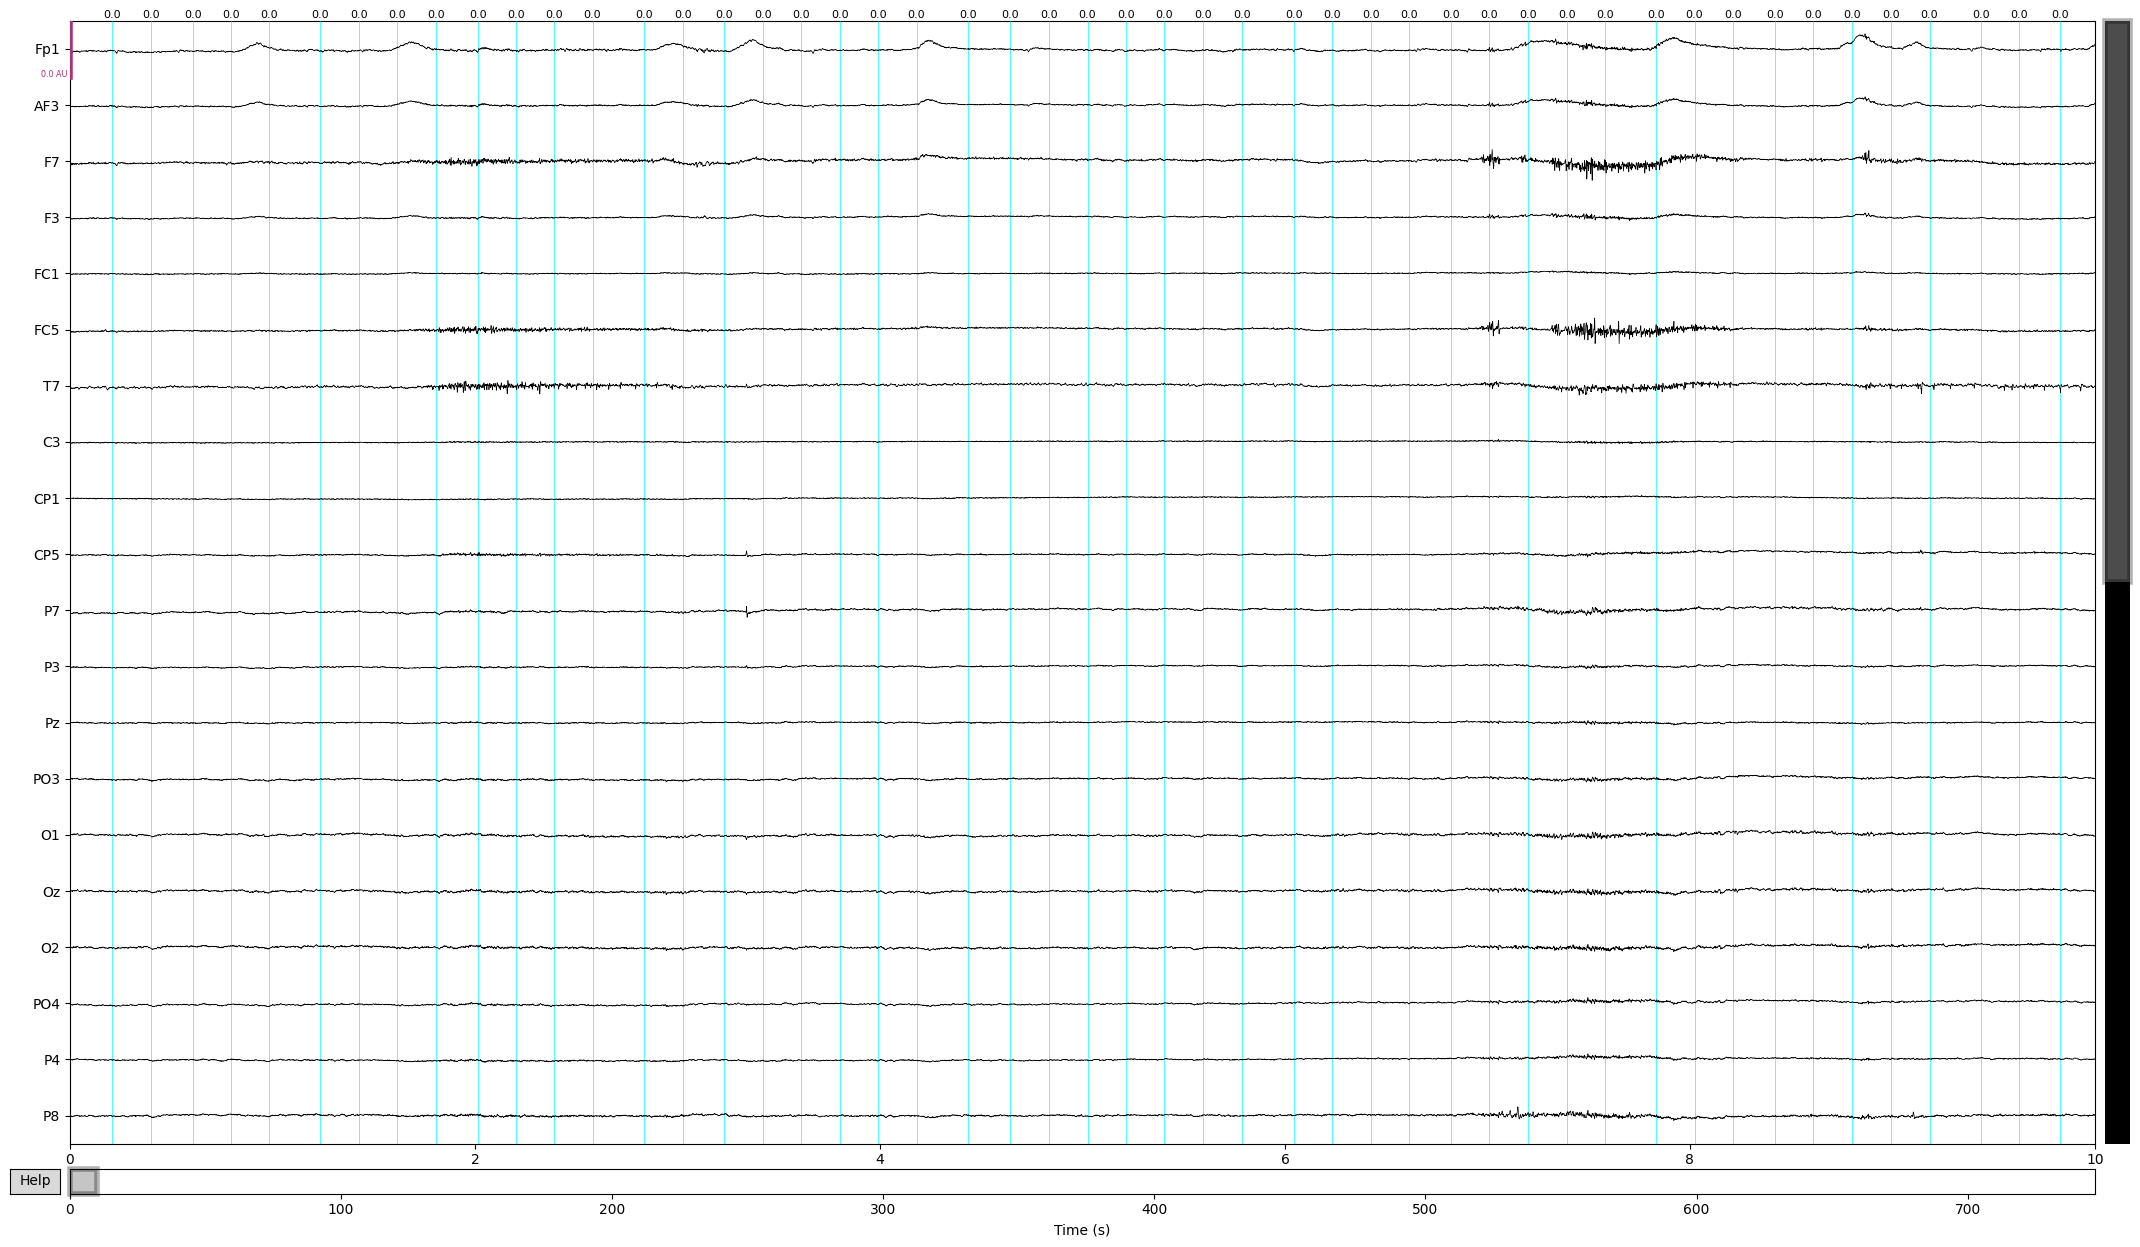

In [96]:
# raw.plot(events)

In [97]:
# Let's start with the most calibration-like case. Are there any instances where we have 19 identical labels in a row?
# Those would be cases of >= 3.75 seconds of motor execution. The EEG model is trained on 3.75 seconds of motor execution.

# good_events = events[starting_points, :]A

In [98]:
import itertools
bits = prediction_values
index = 0
starting_points = []
for bit, group in itertools.groupby(bits):
    length = len(list(group))
    if length >=19:
        starting_points.append(events[index, :])
        print(f"{length / 5} seconds of {events[index, 2]}")
    index += length

# So at the start 
starting_points = np.array(starting_points).astype('int32')
starting_points[:, 0] = starting_points[:, 0] - int(0.2 * 2048)

17.6 seconds of 0.0
5.0 seconds of 1.0
6.6 seconds of 1.0
3.8 seconds of -1.0
7.6 seconds of 1.0
4.2 seconds of 0.0
4.2 seconds of 1.0
4.8 seconds of -1.0
4.6 seconds of -1.0
7.0 seconds of 1.0
4.4 seconds of -1.0
5.2 seconds of -1.0
8.2 seconds of 1.0
3.8 seconds of -1.0
3.8 seconds of -1.0
7.4 seconds of 1.0
6.0 seconds of 1.0
3.8 seconds of -1.0
8.0 seconds of -1.0
6.2 seconds of -1.0
6.8 seconds of 1.0
4.2 seconds of -1.0
3.8 seconds of -1.0
3.8 seconds of 1.0
4.6 seconds of 0.0
4.8 seconds of 1.0
3.8 seconds of -1.0
3.8 seconds of -1.0
4.6 seconds of -1.0
7.4 seconds of 1.0
3.8 seconds of -1.0
7.2 seconds of 1.0
4.4 seconds of -1.0
5.0 seconds of 1.0
3.8 seconds of 0.0
4.2 seconds of 1.0
7.0 seconds of -1.0
4.8 seconds of 1.0
4.6 seconds of 0.0
4.0 seconds of 1.0
8.4 seconds of 0.0
8.0 seconds of 0.0


In [99]:

event_ids = dict(left=-1, rest=0, right=1)
tmin = 0
tmax = 3.75
raw
epochs = mne.Epochs(
        raw,
        starting_points,
        event_ids,
        tmin,
        tmax + 0.5,
        baseline=None,
        preload=True,
        reject_by_annotation=False
    )
epochs

Number of events,42
Events,left: 18rest: 7right: 17
Time range,0.000 – 4.250 s
Baseline,off


In [100]:
starting_points.shape

(42, 3)

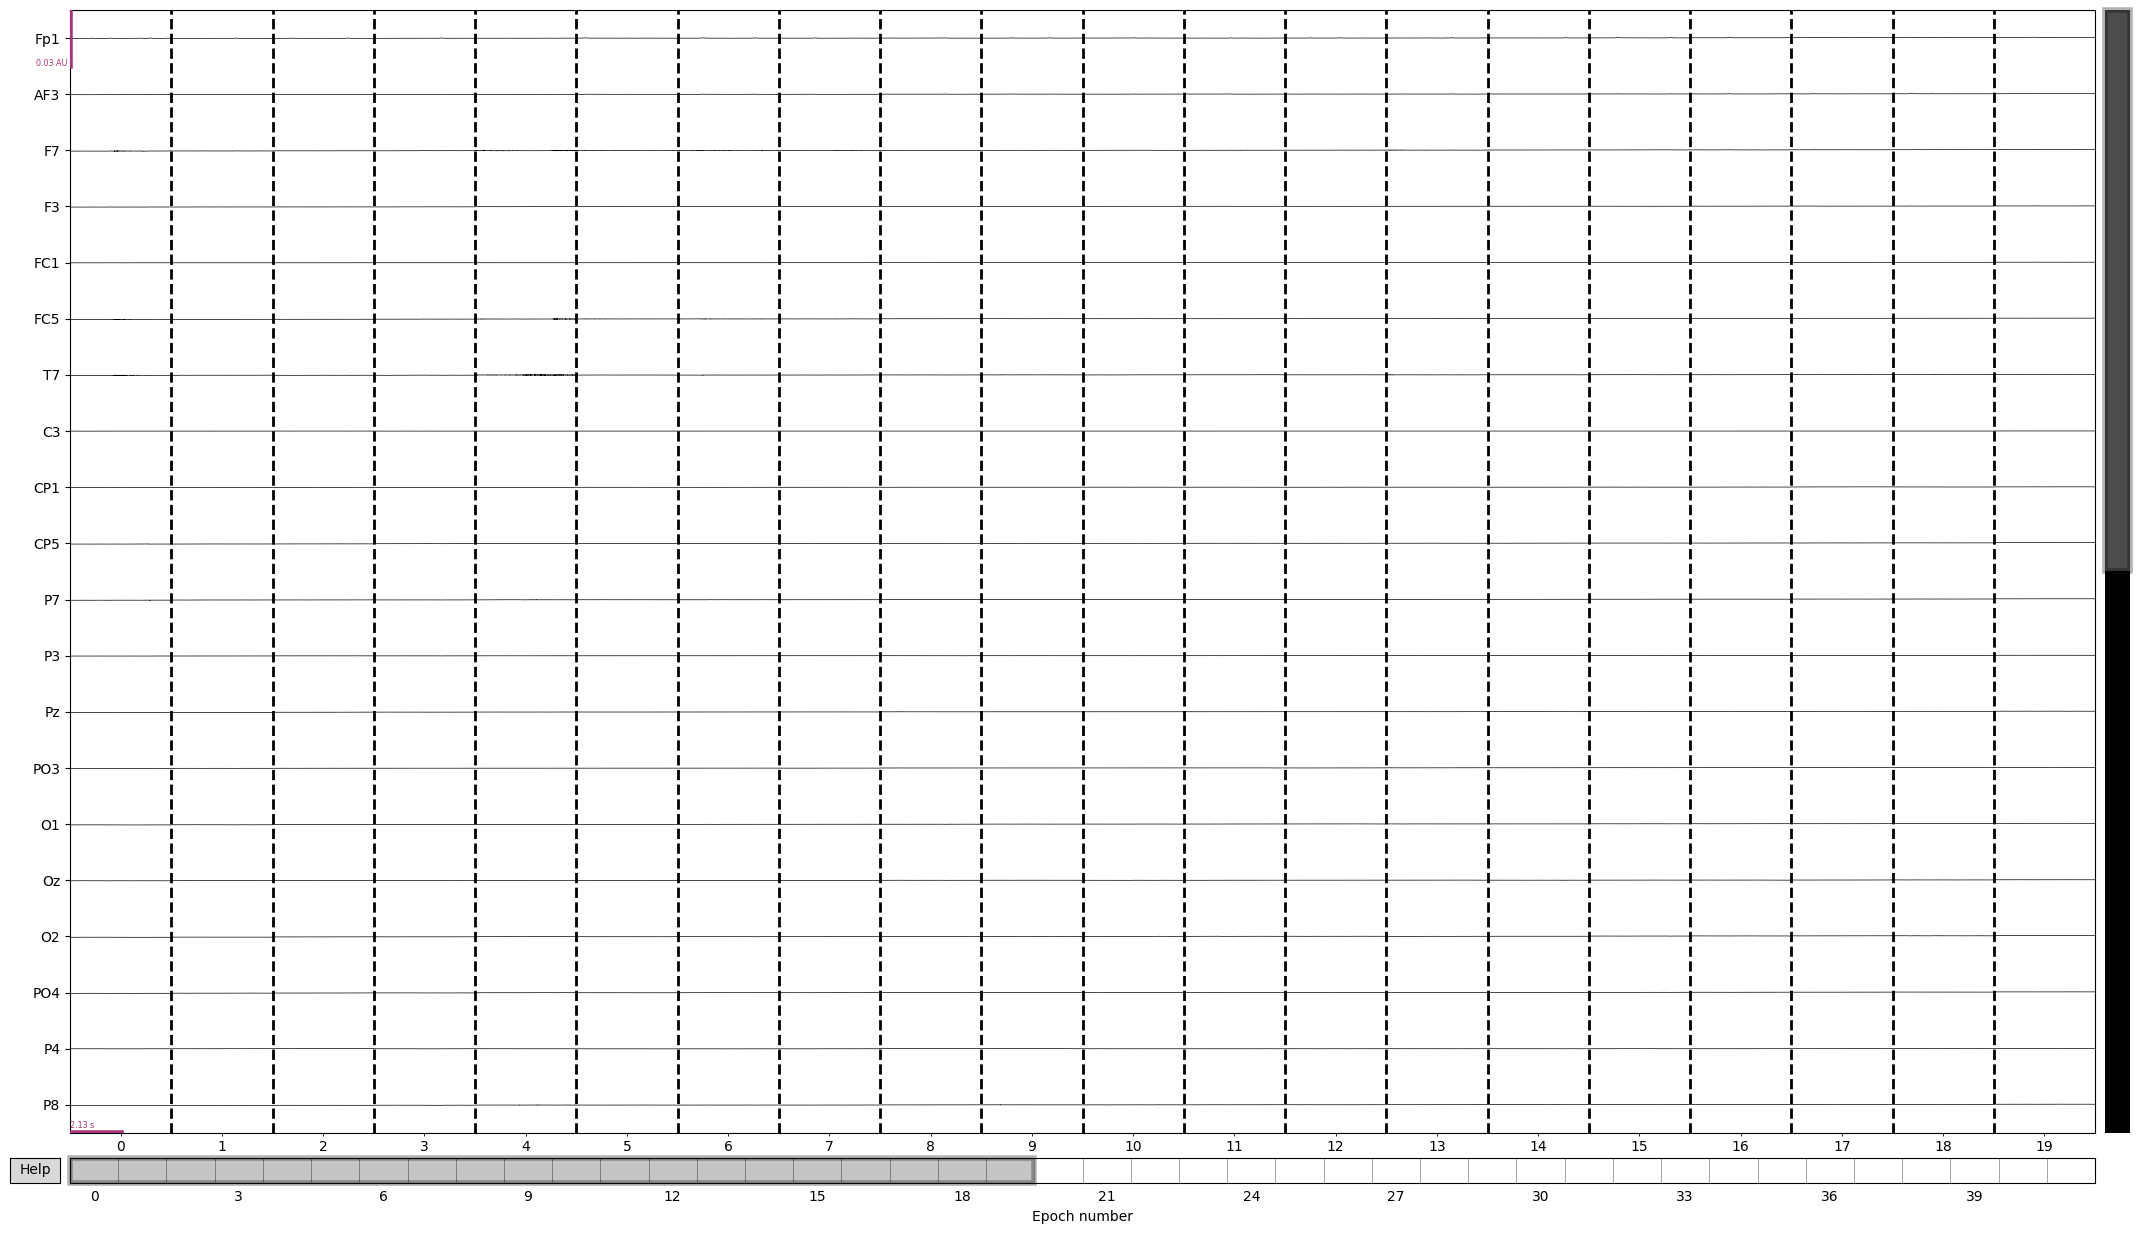

In [101]:
# epochs.plot(picks='all')

In [102]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,40 misc
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [103]:
from continuous_control_bci.data.load_data import load_from_file, adjust_info
from continuous_control_bci.data.preprocessing import apply_causal_filters, make_epochs, epochs_to_train_test
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier
from sklearn.metrics import classification_report


def create_csp_model_from_file(file_path):
    raw = load_from_file(file_path)
    print(np.max(raw.get_data()))
    print(np.min(raw.get_data()))
    raw = raw.set_eeg_reference()
    raw = adjust_info(raw)
    print(raw.get_channel_types())
    # raw = raw.set_eeg_reference()
    raw = apply_causal_filters(raw)
    epochs = make_epochs(raw, include_rest=True)
    print(epochs)
    print(epochs.get_data().shape)
    X_train, _, y_train, _ = epochs_to_train_test(epochs)
    print(X_train.shape)
    print("Training classifier. This may take a while..")
    clf, y_pred = create_csp_classifier(X_train, y_train)
    print("Classifier trained!")
    print(classification_report(y_train, y_pred, target_names=["Left", "Right", "Rest"]))
    return clf, X_train
    
mne.set_log_level('warning') # noqa
clf, X_train = create_csp_model_from_file('../data/pilot_1/calibration/horse_reighns_pilot_driving.gdf')

0.01860375
-0.018577187499999998
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'emg', 'emg', 'emg', 'emg', 'eog', 'eog', 'eog', 'eog']
<Epochs |  80 events (all good), -0.100098 – 6.5 s, baseline off, ~330.1 MB, data loaded,
 'left': 20
 'right': 20
 'rest': 40>
(80, 40, 13518)
(72, 32, 13518)
Training classifier. This may take a while..


/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_12019/2592165917.py:18: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape)


Classifier trained!
              precision    recall  f1-score   support

        Left       0.71      0.71      0.71        17
       Right       0.93      0.81      0.87        16
        Rest       0.88      0.92      0.90        39

    accuracy                           0.85        72
   macro avg       0.84      0.81      0.82        72
weighted avg       0.85      0.85      0.85        72



In [104]:
eeg_mapping = {name: type for name, type in zip(channel_names[:-8], ["eeg"] * len(channel_names[:-8]))}
emg_mapping = {name: type for name, type in zip(channel_names[-8:-4], ["emg"] * 4)}
eog_mapping = {name: type for name, type in zip(channel_names[-4:], ["eog"] * 4)}



channel_type_mapping = {
    **eeg_mapping,
    **emg_mapping,
    **eog_mapping,
}

wrong_channel_type_mapping = {
    name: type for name, type in zip(channel_names, ["eeg"] * len(channel_names))
}


# The problem is that the EEG is rereferences originally with EMG and EOG. This is silly, but convenient.
# We need a way to deal with this. The easy hack for now is to rereference it in the same way
# Though the correct way is to rereference EEG with EEG and EMG with EMG. Becomes a bit silly that EMG might not work because T7 is bad

raw = mne.io.RawArray(eeg_streams[1:41, :] / 10e5, info=mne.create_info(channel_names, sfreq=2048))

# raw = raw.set_channel_types(wrong_channel_type_mapping)
# raw = raw.set_eeg_reference()
raw = raw.set_channel_types(channel_type_mapping)
raw = raw.set_montage("biosemi32", on_missing='raise')
raw = raw.set_eeg_reference()
# raw = apply_causal_filters(raw, l_eeg=2)
raw = raw.filter(l_freq=2, h_freq=35, picks='eeg')
raw

/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_12019/2961926455.py:26: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  raw = raw.set_channel_types(channel_type_mapping)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,35.00 Hz


In [105]:
# raw.plot()
# plt.show()

In [106]:
raw.set_annotations(mne.read_annotations("hand_annot.fif"))


/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_12019/704263958.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations("hand_annot.fif"))


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,35.00 Hz


In [107]:
ica = mne.preprocessing.ICA(random_state=42)
ica.fit(raw, picks=['eeg'])

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,41 iterations on raw data (1476919 samples)
ICA components,31
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [108]:
ica.find_bads_eog(raw)

([0, 1],
 [array([-0.21158362, -0.76959766, -0.21036654,  0.08037638,  0.1016738 ,
         -0.03384374,  0.15984525,  0.16176644,  0.10584344, -0.10774773,
          0.10812512,  0.0020673 , -0.06126951, -0.03148166,  0.02256999,
          0.04444328,  0.00879069,  0.02416302, -0.03770861, -0.0487688 ,
         -0.06498216,  0.00862736, -0.01416529, -0.10298092,  0.02454457,
         -0.05865006,  0.07030966,  0.06558429,  0.03652304,  0.00393792,
         -0.02703518]),
  array([-1.25529564e-01,  7.63843794e-01, -2.33333908e-01, -2.28994249e-01,
          1.02261936e-01, -4.73805775e-03,  2.02568129e-01,  1.57710271e-01,
          6.10097947e-04, -1.82140020e-01,  2.81248469e-02,  1.41416647e-02,
          4.86219136e-03, -1.53230684e-02,  3.56216161e-02, -1.93424409e-03,
         -2.72281276e-02, -1.94314379e-02, -1.99257914e-01, -1.07173713e-01,
         -7.98464890e-02,  4.59893238e-02,  4.07586996e-02, -9.52905277e-02,
          2.53667147e-02, -3.45648593e-02,  2.79705921e-02,  

In [112]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x731 with 11 Axes>]

In [110]:
# ica.plot_properties(raw)

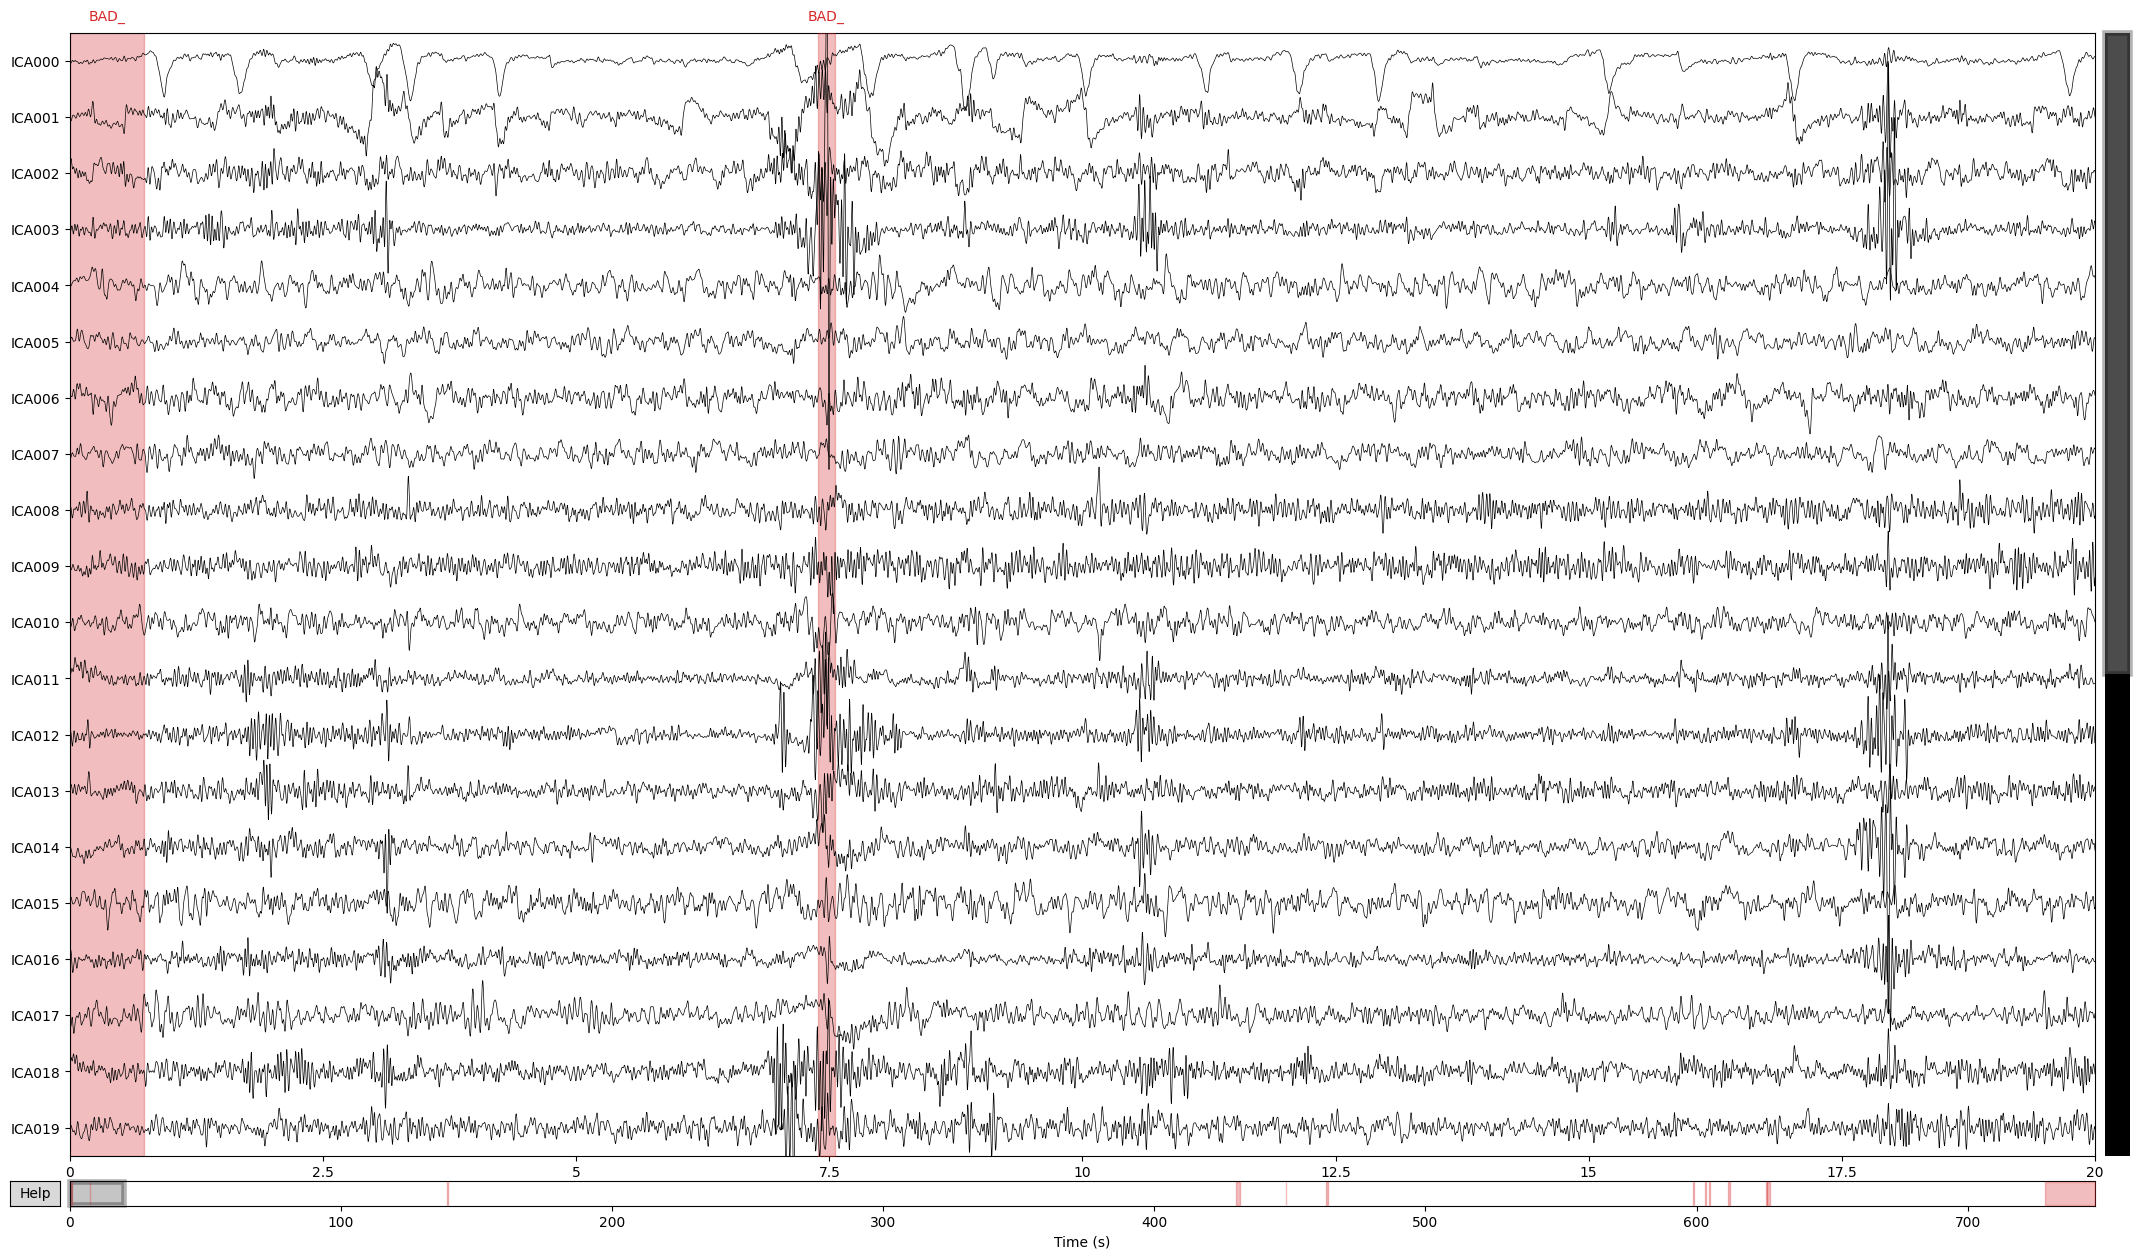

In [113]:
ica.plot_sources(raw)

In [115]:
ica.exclude = ['ICA000', 'ICA001', 'ICA003', 'ICA008', 'ICA009', 'ICA011', 'ICA016', 'ICA021', 'ICA029']


In [116]:
raw = ica.apply(raw)

In [122]:
# Time for the ol' ERDS map

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5548638/
# Based on figure 4 in the above paper we can loosely assume that the anticipation is 1 second before the movement. They made the same assumption.
# Then we baseline is to [-2, -1] so we can see anticipation effect and the actual movement separately

tmin = 0
tmax = 3.75
event_ids = dict(left=-1,  rest=0, right=1)
edge_effect_buffer = 0.5
baseline_start = -2
baseline_end = -1
epochs = mne.Epochs(
    raw,
    starting_points,
    event_ids,
    tmin + baseline_start - edge_effect_buffer,
    tmax + edge_effect_buffer,
    picks=("C3", "Cz", "C4", 'Left-flexion', 'Right-flexion'),
    baseline=None,
    preload=True,
)

epochs.plot(events=starting_points, picks=['all'])
plt.show()
print(epochs)



<Epochs |  34 events (all good), -2.5 – 4.25 s, baseline off, ~18.0 MB, data loaded,
 'left': 16
 'rest': 2
 'right': 16>


In [127]:
print(epochs)

<Epochs |  20 events (all good), -2.5 – 4.25 s, baseline off, ~10.6 MB, data loaded,
 'left': 7
 'rest': 2
 'right': 11>


In [129]:
epochs = epochs.pick(("C3", "Cz", "C4"))

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 2  # set min and max ERDS values in plot
baseline = (baseline_start, baseline_end)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(baseline_start, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        # print(len(c1))
        # print(len(c2))
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu_r",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            # mask=mask,
            # mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [73]:
np.diff(starting_points[:, 0]) / 2048

array([22.8203125 , 48.59130859, 43.58837891, 28.58691406,  8.79833984,
        6.21142578,  8.78955078, 36.59521484,  6.60205078, 12.05371094,
       12.75048828,  6.41748047, 17.43701172, 11.34130859, 16.03662109,
       18.58642578, 27.43505859, 14.99560547, 32.94970703,  7.64013672,
       12.1640625 , 18.41259766, 19.60302734,  8.79003906,  9.0390625 ,
        9.36816406,  4.60986328, 30.37792969,  6.80419922,  9.60595703,
       21.42675781, 12.35595703, 32.83691406, 11.39794922,  8.20214844,
        8.59570312, 40.38330078, 45.20019531, 22.04638672,  6.40917969,
        9.93945312])

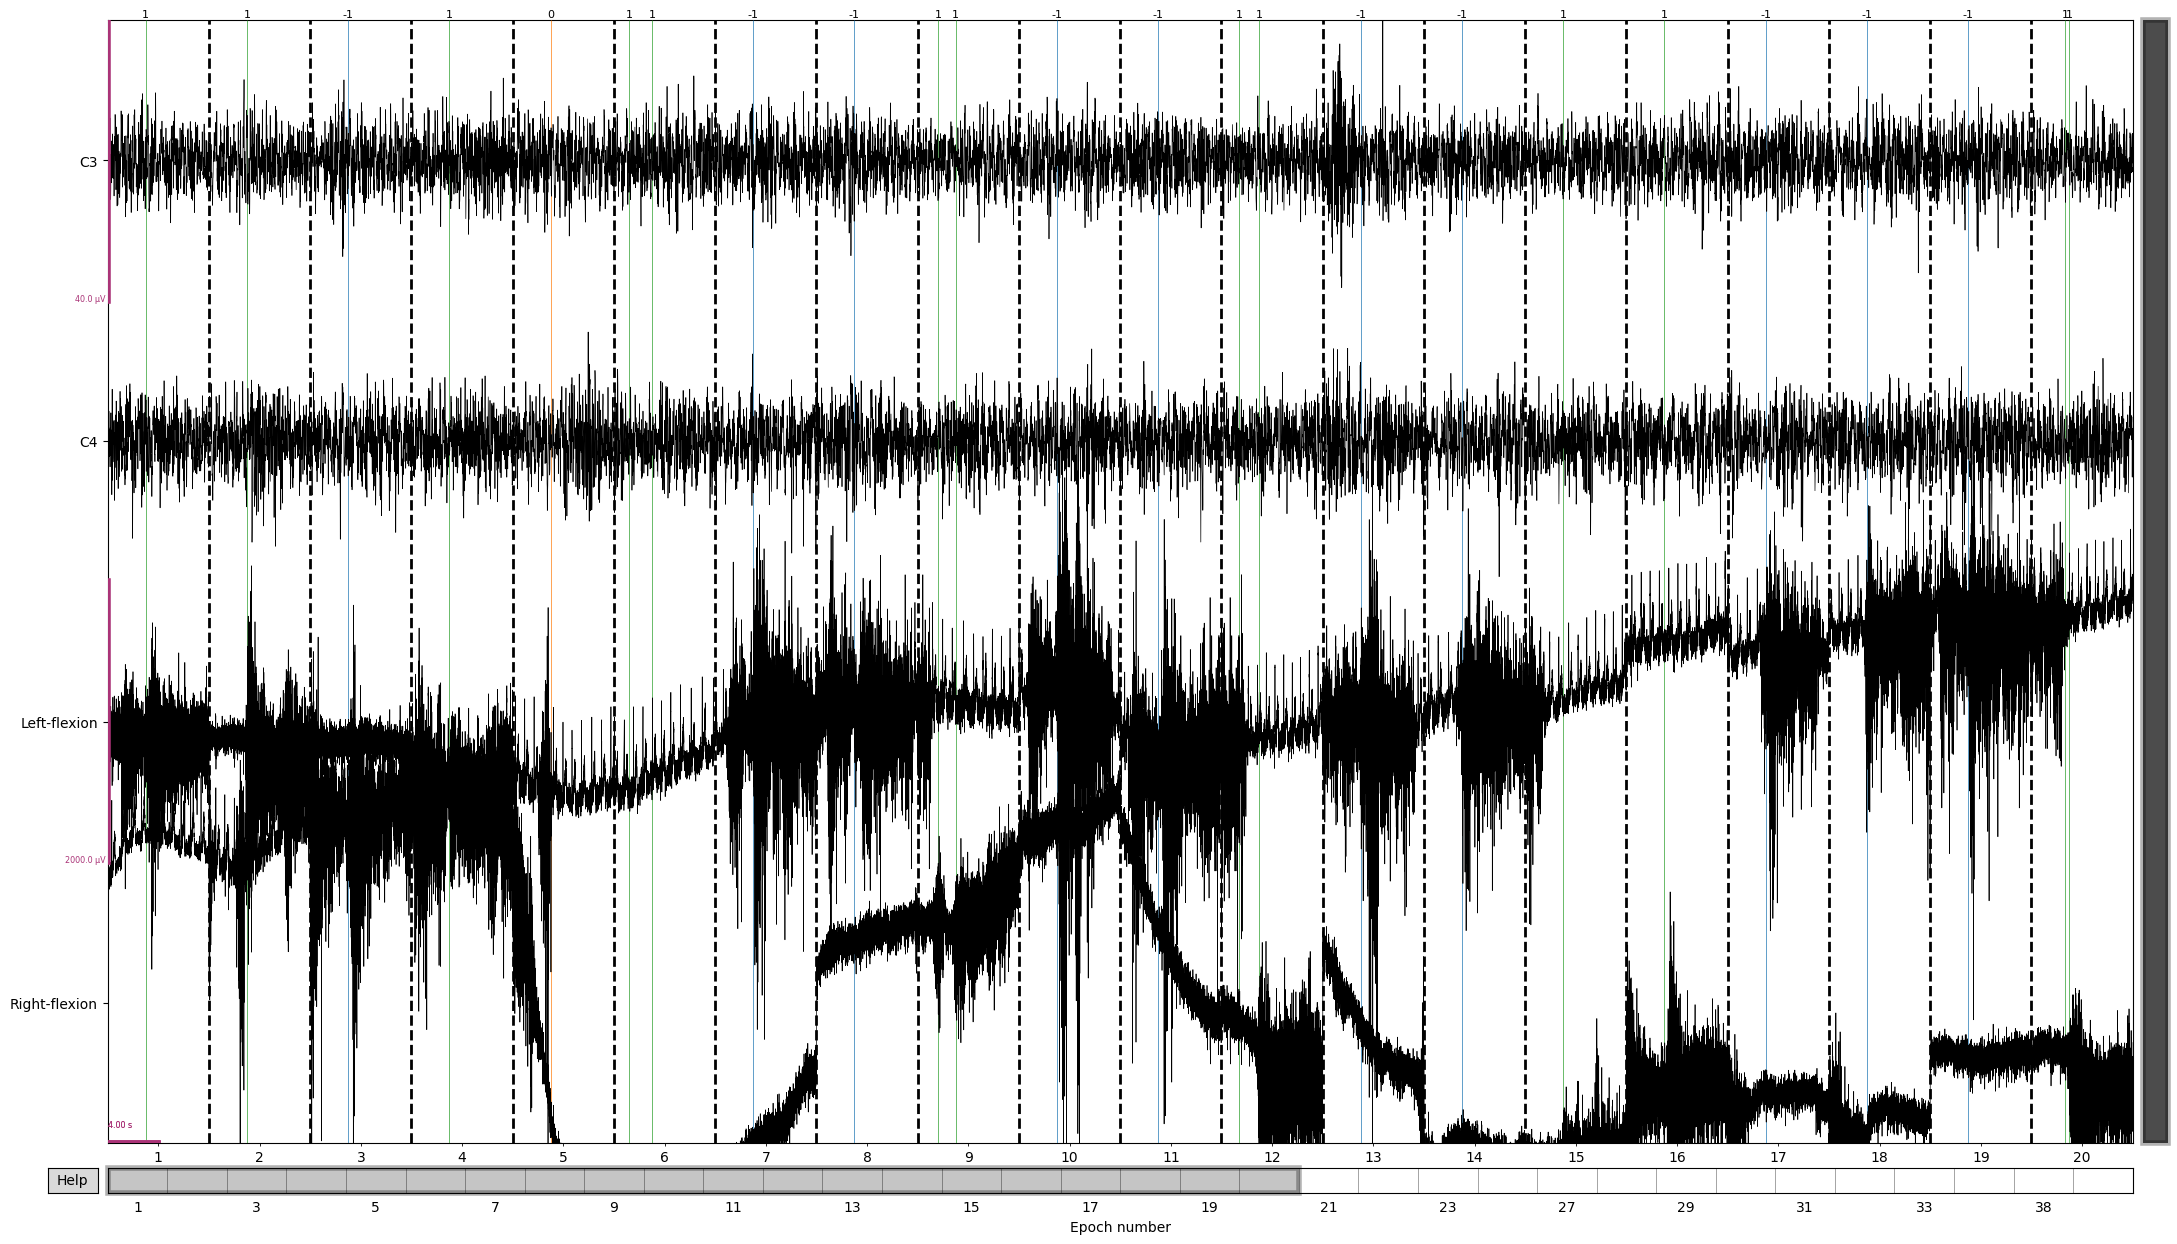

In [82]:
starting_points
epochs = mne.Epochs(
    raw,
    starting_points,
    event_ids,
    -3,
    5,
    picks=("C3", "C4",  'Left-flexion', 'Right-flexion'),
    baseline=None,
    preload=True,
)
epochs.plot(picks=("C3", "C4",  'Left-flexion', 'Right-flexion'), events=starting_points)

In [86]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"2 EEG, 2 EMG"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,35.00 Hz


In [84]:
epochs

Number of events,19
Events,left: 8rest: 2right: 9
Time range,-3.000 – 5.000 s
Baseline,off


In [23]:
# csp = clf.steps[0][1]
# csp.plot_patterns(raw.pick(['eeg']).info)
# plt.show()

In [ ]:


epochs = mne.Epochs(
    raw,
    starting_points,
    dict(left=-1),
    tmin - 0.1,
    tmax + 0.5,
    picks='all',
    baseline=None,
    preload=True,
)
print(epochs)
epochs.compute_psd().plot_topomap()

<Epochs |  17 events (all good), -0.100098 – 4.25 s, baseline off, ~46.3 MB, data loaded,
 'right': 17>


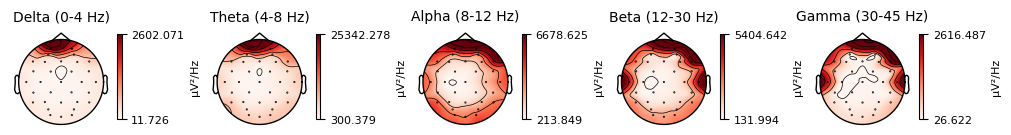

In [25]:
epochs = mne.Epochs(
    raw,
    starting_points,
    dict(right=1),
    tmin - 0.1,
    tmax + 0.5,
    picks='all',
    baseline=None,
    preload=True,
)
print(epochs)
epochs.compute_psd().plot_topomap()

In [26]:
raw.get_data().shape

(40, 1529828)

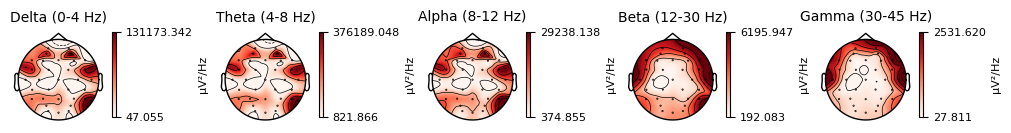

In [27]:
epochs = mne.Epochs(
    raw,
    starting_points,
    event_ids,
    tmin - 0.1,
    tmax + 0.5,
    picks='all',
    baseline=None,
    preload=True,
)
epochs.compute_psd().plot_topomap()

In [28]:
print(event_ids)

{'left': -1, 'rest': 0, 'right': 1}


In [29]:
y_true = epochs.events[:, -1]

In [30]:
y_pred = clf.predict(epochs.get_data())

/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_70056/2768461441.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  y_pred = clf.predict(epochs.get_data())


ValueError: shapes (4,32) and (40,8910) not aligned: 32 (dim 1) != 40 (dim 0)

In [ ]:
y_pred

In [ ]:
csp.transform_into = 'average_power'

In [ ]:
X_csp = csp.transform(epochs.get_data())

In [ ]:
import pandas as pd

pd.plotting.scatter_matrix(pd.DataFrame(X_csp), c=epochs.events[:, -1])

In [ ]:
print(classification_report(y_true, y_pred, target_names=["Left", "Rest", "Right"]))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Left", "Rest", "Right"],
                                            normalize='true')
plt.show()

In [ ]:
print((epochs.get_data() / 1000).mean())
print((epochs.get_data(units='V') / 1000).std())

In [ ]:
print(X_train.mean())
print(X_train.std())

In [ ]:
print(X_train.shape)

In [ ]:
raw

2024-01-09 16:03:31.837 Python[70056:15912922] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
